In [502]:
import numpy as np
import scipy
import sklearn.svm
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

In [475]:
M = scipy.stats.multivariate_normal(mean=np.zeros(2), cov=3)
D = scipy.stats.multivariate_normal(mean=np.zeros(2), cov=1)

def sample_dataset(means, N=100):
    K = means.shape[0]
    mean_choice = np.random.choice(K, size=N)
    distortion = D.rvs(N)
    return means[mean_choice] + distortion

def pdf_means(means, x):
    K = means.shape[0]
    p = np.zeros(x.shape[0])
    for m in means:
        p += 1/K * scipy.stats.multivariate_normal.pdf(x, mean=m, cov=1)
    return p
    
def sample_means(K=5):
    return M.rvs(K)

def bundle_data(data_class1, data_class2):
    data_all = np.concatenate([data_class1, data_class2])
    labels_all = np.concatenate([
        np.zeros(data_class1.shape[0]) + 1, np.zeros(data_class2.shape[0]) + 2
    ])
    return data_all, labels_all

def sample_datasets(means_class1, means_class2, M=100, N=100):
    datasets = []
    for i in range(M):
        data_class1 = sample_dataset(means_class1, N)
        data_class2 = sample_dataset(means_class2, N)
        datasets.append(bundle_data(data_class1, data_class2))
    return datasets

In [472]:
np.random.seed(189)
means_class1 = sample_means() + np.array([0, 2.5])
means_class2 = sample_means() + np.array([2.5, 0])

In [473]:
def plot_data(plt, dataset, means=False, alpha=0.2):
    data, labels = dataset
    data_class1 = data[labels == 1.0]
    data_class2 = data[labels == 2.0]
    if means:
        plt.scatter(*means_class1.T, label='class 1 means', color='blue', marker='o', linewidths=5)
        plt.scatter(*means_class2.T, label='class 2 means', color='gold', marker='o', linewidths=5)
    plt.scatter(*data_class1.T, label='class 1 datapoints', alpha=alpha, color='blue')
    plt.scatter(*data_class2.T, label='class 2 datapoints', alpha=alpha, color='gold')

In [416]:
plot_dataset = sample_datasets(means_class1, means_class2, M=1, N=500)[0]

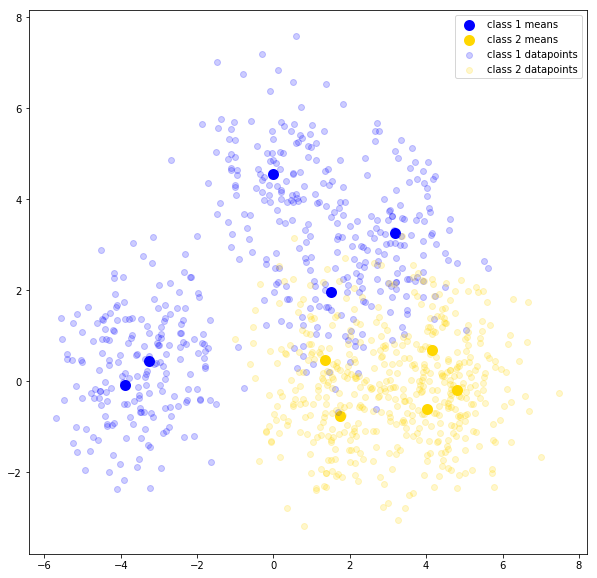

In [481]:
plt.figure(figsize=(10 , 10))
plot_data(plt,plot_dataset, means=True)
plt.legend()
plt.show()

In [ ]:
def plot_bayes(plt, )

In [482]:
def plot_svc(plt, X1, X2, svc, support_vectors=True):
    X1X2 = np.stack([X1.ravel(), X2.ravel()]).T
    Z = svc.decision_function(X1X2).reshape(X1.shape)
    plt.contour(X1, X2, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
    if support_vectors:
        plt.scatter(*svc.support_vectors_.T, s=100, linewidth=1, facecolors='None', edgecolors='k')

In [483]:
def train_svcs(train_dataset, C):
    train_data, train_labels = train_dataset
    result = []
    for c in C:
        svc = sklearn.svm.SVC(kernel='linear', C=c)
        svc.fit(train_data, train_labels)
        result.append(svc)
    return np.array(result)

def plot_svcs(plt, dataset, svcs, support_vectors=True):
    dataset_x, _ = dataset
    X1_o = np.linspace(dataset_x[:, 0].min(), dataset_x[:, 0].max())
    X2_o = np.linspace(dataset_x[:, 1].min(), dataset_x[:, 1].max())
    X1, X2 = np.meshgrid(X1_o, X2_o)
    if len(svcs.shape) == 1:
        svcs = svcs.reshape((1, -1))
    counter = np.arange(1, svcs.size + 1).reshape(svcs.shape)
    join = np.stack([svcs, counter], axis=2)
    for row in join:
        for (svc, i) in row:
            subplt = plt.subplot(svcs.shape[0], svcs.shape[1], i)
            plot_svc(subplt, X1, X2, svc, support_vectors=support_vectors)
            plot_data(subplt, dataset)
            subplt.title.set_text("For C={}".format(svc.C))

In [800]:
sm_train_data = sample_datasets(means_class1, means_class2, M=1, N=20)[0]
svcs = train_svcs(sm_train_data, [0.01, 0.1, 1, 10])

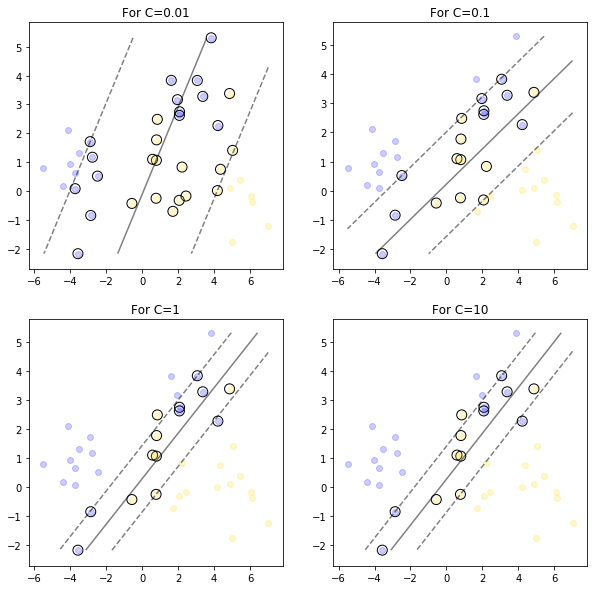

In [801]:
plt.figure(figsize=(10, 10))
plot_svcs(plt, sm_train_data, svcs.reshape((2, 2,)))
plt.show()

In [599]:
test_dataset = sample_datasets(means_class1, means_class2, M=1, N=500)[0]

In [600]:
many_datasets = sample_datasets(means_class1, means_class2, M=1000, N=5)

In [648]:
def measure_empirical_bv(train_datasets, test_dataset, C):
    test_x, test_labels = test_dataset
    predicted_labels = np.zeros((len(C), len(train_datasets), test_labels.shape[0]))
    train_err = np.zeros((len(C), len(train_datasets)))
    support_vectors = np.zeros((len(C), len(train_datasets)))
    coeffs = np.zeros((len(C), len(train_datasets), 3))
    for (i, train_dataset) in enumerate(train_datasets):
        (train_x, train_labels) = train_dataset
        svcs = train_svcs(train_dataset, C)
        for j, svc in enumerate(svcs):
            predicted_labels[j, i, :] = svc.predict(test_x)
            train_err[j, i] = ((svc.predict(train_x) - train_labels) ** 2).mean()
            support_vectors[j, i] = svc.support_vectors_.shape[0]
            coeffs[j, i, 0:2] = svc.coef_
            coeffs[j, i, 2:3] = svc.intercept_
        print("dataset {}/{}".format(i+1,len(train_datasets)), end='\r')
    print("dataset {}/{}".format(len(train_datasets), len(train_datasets)))
    # square is technically useless here, but whatever
    mean_prediction = predicted_labels.mean(axis=1)
    bias_2 = (mean_prediction - test_labels) ** 2
    variance = predicted_labels.var(axis=1)
    mse = ((predicted_labels - test_labels) ** 2).mean(axis=1)
    return mse, bias_2, variance, train_err.mean(axis=1), support_vectors.mean(axis=1), coeffs

In [649]:
fake_dataset = (np.array([[0, 0], [1, 0], [0, 1], [1, 1]]), np.array([2.0, 2.0, 2.0, 1.0]))

In [784]:
test_C = np.array([0.01, 0.1, 0.5, 0.7, 0.9, 1, 10, 100, 1000])
log_test_C = np.log10(test_C)

In [785]:
mse, bias_2, variance, train_err, sup_vec, coeffs = measure_empirical_bv(many_datasets, test_dataset, 
                     C=test_C)

dataset 1000/1000


In [786]:
troublesome_testpoints = sorted(np.arange(1000), key=lambda i: -variance[:, i].mean())[:10]
trouble_dataset = (test_dataset[0][troublesome_testpoints], test_dataset[1][troublesome_testpoints])

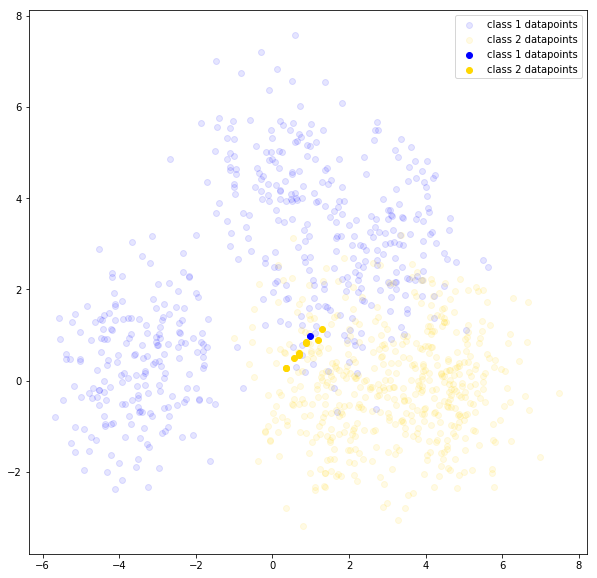

In [787]:
plt.figure(figsize=(10 , 10))
plot_data(plt,plot_dataset, alpha=0.1)
plot_data(plt, trouble_dataset, alpha=1)
plt.legend()
plt.show()

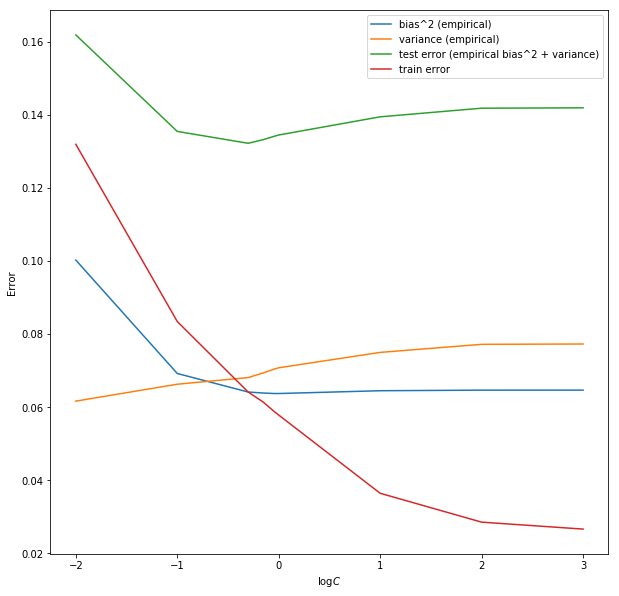

In [788]:
plt.figure(figsize=(10, 10))
plt.plot(log_test_C, bias_2.mean(axis=1), label='bias^2 (empirical)')
plt.plot(log_test_C, variance.mean(axis=1), label='variance (empirical)')
plt.plot(log_test_C, mse.mean(axis=1), label='test error (empirical bias^2 + variance)')
plt.plot(log_test_C, train_err, label='train error')
plt.xlabel('$\log C$')
plt.ylabel('Error')
plt.legend()
plt.show()

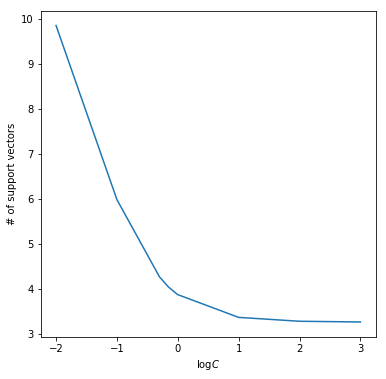

In [789]:
plt.figure(figsize=(6, 6))
plt.plot(log_test_C, sup_vec)
plt.xlabel('$\log C$')
plt.ylabel('# of support vectors')
plt.show()

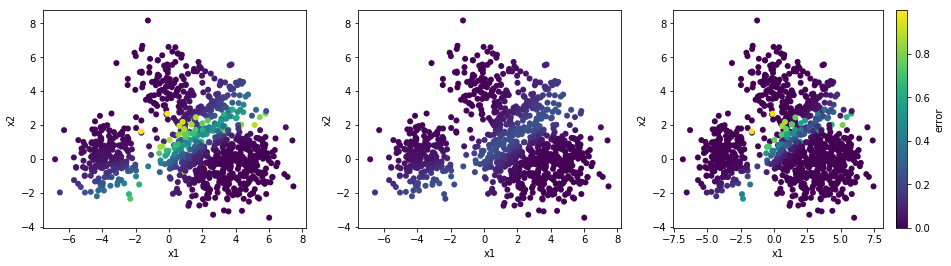

In [828]:
all_E = np.concatenate([mse[5], variance[5], bias_2[5]])
vmin, vmax = all_E.min(), all_E.max()
plt.figure(figsize=(16, 4))
subplt = plt.subplot(1, 3, 1)
sc = subplt.scatter(test_dataset[0][:, 0], test_dataset[0][:, 1], c=mse[5], linewidths=0.01, vmin=vmin, vmax=vmax)
# plt.colorbar(sc, label="mse", ax=subplt)
subplt.set_xlabel("x1")
subplt.set_ylabel("x2")
subplt = plt.subplot(1, 3, 2)
sc = subplt.scatter(test_dataset[0][:, 0], test_dataset[0][:, 1], c=variance[5], linewidths=0.01, vmin=vmin, vmax=vmax)
# plt.colorbar(sc, label="variance", ax=subplt)
subplt.set_xlabel("x1")
subplt.set_ylabel("x2")
subplt = plt.subplot(1, 3, 3)
sc = subplt.scatter(test_dataset[0][:, 0], test_dataset[0][:, 1], c=bias_2[5], linewidths=0.01, vmin=vmin, vmax=vmax)
subplt.set_xlabel("x1")
subplt.set_ylabel("x2")
plt.colorbar(sc, label="error", ax=subplt)
plt.show()

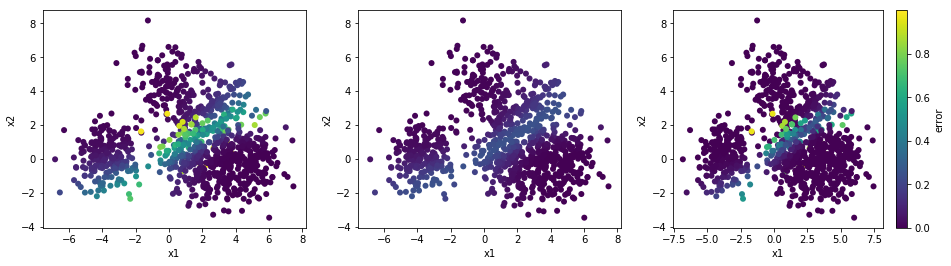

In [829]:
all_E = np.concatenate([mse[7], variance[7], bias_2[7]])
vmin, vmax = all_E.min(), all_E.max()
plt.figure(figsize=(16, 4))
subplt = plt.subplot(1, 3, 1)
sc = subplt.scatter(test_dataset[0][:, 0], test_dataset[0][:, 1], c=mse[7], linewidths=0.01, vmin=vmin, vmax=vmax)
# plt.colorbar(sc, label="mse", ax=subplt)
subplt.set_xlabel("x1")
subplt.set_ylabel("x2")
subplt = plt.subplot(1, 3, 2)
sc = subplt.scatter(test_dataset[0][:, 0], test_dataset[0][:, 1], c=variance[7], linewidths=0.01, vmin=vmin, vmax=vmax)
# plt.colorbar(sc, label="variance", ax=subplt)
subplt.set_xlabel("x1")
subplt.set_ylabel("x2")
subplt = plt.subplot(1, 3, 3)
sc = subplt.scatter(test_dataset[0][:, 0], test_dataset[0][:, 1], c=bias_2[7], linewidths=0.01, vmin=vmin, vmax=vmax)
subplt.set_xlabel("x1")
subplt.set_ylabel("x2")
plt.colorbar(sc, label="error", ax=subplt)
plt.show()

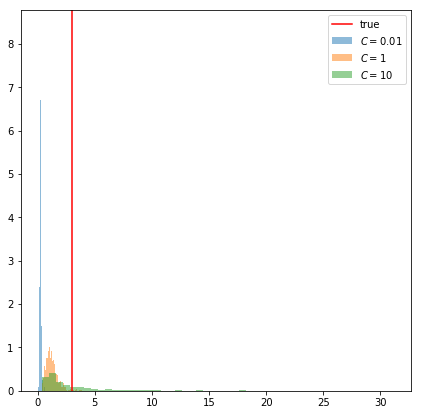

In [795]:
plt.figure(figsize=(7, 7))
plt.hist(np.linalg.norm(coeffs[0, :, :], axis=1), alpha=0.5, label='$C=0.01$', density=True, bins=50)
plt.hist(np.linalg.norm(coeffs[5, :, :], axis=1), alpha=0.5, label='$C=1$', density=True, bins=50)
plt.hist(np.linalg.norm(coeffs[7, :, :], axis=1), alpha=0.5, label='$C=10$', density=True, bins=50)
plt.axvline(np.linalg.norm(coeffs.mean(axis=1)[8]), color='red', label='true')
plt.legend()
plt.show()

In [802]:
lg_dataset=sample_datasets(means_class1, means_class2, M=1, N=1000)[0]

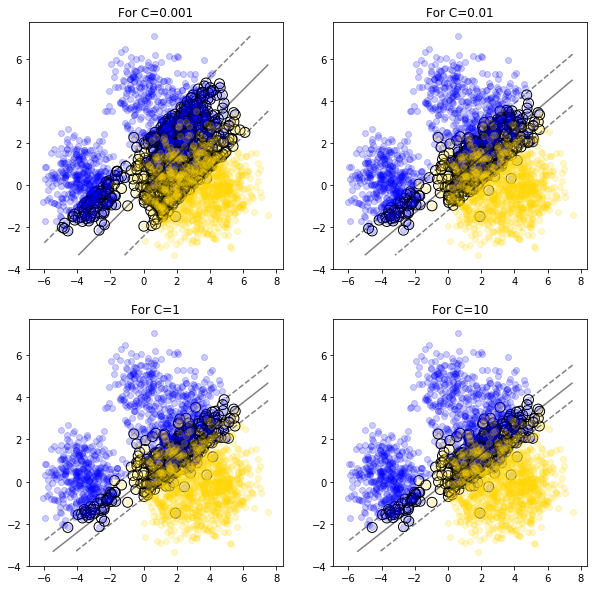

In [803]:
svcs = train_svcs(lg_dataset, [0.001, 0.01, 1, 10])
plt.figure(figsize=(10, 10))
plot_svcs(plt, lg_dataset, svcs.reshape((2, 2,)))
plt.show()

In [827]:
np.concatenate([[svc.coef_[0] for svc in svcs], [svc.intercept_ for svc in svcs]], axis=1)

array([[ 3.58370441e-01, -4.52370631e-01, -1.00216742e-01],
       [ 5.48699784e-01, -8.23551893e-01, -4.57107284e-04],
       [ 7.34711632e-01, -1.18822873e+00,  5.75216126e-02],
       [ 7.36312284e-01, -1.18931501e+00,  5.48437360e-02]])